In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [76]:
import lightgbm as lgb

print(lgb.__version__)

4.6.0


## Load Data and Preprocessing

In [77]:
hr_data = pd.read_csv("hr_analytics.csv")

hr_data.head().T

,0,1,2,3,4
employee_id,65438,65141,7513,2542,48945
department,Sales & Marketing,Operations,Sales & Marketing,Sales & Marketing,Technology
region,region_7,region_22,region_19,region_23,region_26
education,Master's & above,Bachelor's,Bachelor's,Bachelor's,Bachelor's
gender,f,m,m,m,m
recruitment_channel,sourcing,other,sourcing,other,other
no_of_trainings,1,1,1,2,1
age,35,30,34,39,45
previous_year_rating,5.0,5.0,3.0,1.0,3.0
length_of_service,8,4,7,10,2


In [78]:
hr_data.shape

(54735, 13)

In [79]:
hr_data.isnull().sum()

employee_id                0
department                 0
region                     0
education               2406
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4119
length_of_service          0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

Drop irrelevant columns

In [80]:
hr_data.drop("employee_id", axis=1, inplace=True)

hr_data.head().T

,0,1,2,3,4
department,Sales & Marketing,Operations,Sales & Marketing,Sales & Marketing,Technology
region,region_7,region_22,region_19,region_23,region_26
education,Master's & above,Bachelor's,Bachelor's,Bachelor's,Bachelor's
gender,f,m,m,m,m
recruitment_channel,sourcing,other,sourcing,other,other
no_of_trainings,1,1,1,2,1
age,35,30,34,39,45
previous_year_rating,5.0,5.0,3.0,1.0,3.0
length_of_service,8,4,7,10,2
awards_won?,0,0,0,0,0


In [81]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54735 entries, 0 to 54734
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54735 non-null  object 
 1   region                54735 non-null  object 
 2   education             52329 non-null  object 
 3   gender                54735 non-null  object 
 4   recruitment_channel   54735 non-null  object 
 5   no_of_trainings       54735 non-null  int64  
 6   age                   54735 non-null  int64  
 7   previous_year_rating  50616 non-null  float64
 8   length_of_service     54735 non-null  int64  
 9   awards_won?           54735 non-null  int64  
 10  avg_training_score    54735 non-null  int64  
 11  is_promoted           54735 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 5.0+ MB


In [82]:
categorical_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel']

for col in categorical_cols:
    hr_data[col] = hr_data[col].astype('category')
    
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54735 entries, 0 to 54734
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   department            54735 non-null  category
 1   region                54735 non-null  category
 2   education             52329 non-null  category
 3   gender                54735 non-null  category
 4   recruitment_channel   54735 non-null  category
 5   no_of_trainings       54735 non-null  int64   
 6   age                   54735 non-null  int64   
 7   previous_year_rating  50616 non-null  float64 
 8   length_of_service     54735 non-null  int64   
 9   awards_won?           54735 non-null  int64   
 10  avg_training_score    54735 non-null  int64   
 11  is_promoted           54735 non-null  int64   
dtypes: category(5), float64(1), int64(6)
memory usage: 3.2 MB


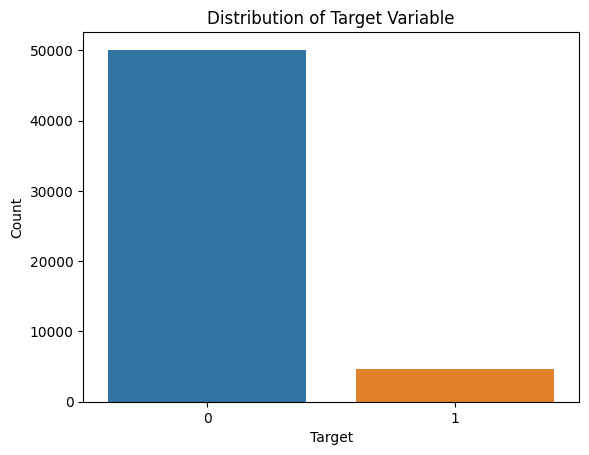

In [83]:
target_counts = hr_data['is_promoted'].value_counts()

sns.barplot(x=target_counts.index, y=target_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

In [84]:
X = hr_data.drop('is_promoted', axis=1)
y = hr_data['is_promoted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

X_train.shape, X_test.shape

((38314, 11), (16421, 11))

In [85]:
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=100,
    random_state=42,
    verbose=-1
)

lgbm_clf.fit(X_train, y_train)

print("LightGBM model trained successfully.")

LightGBM model trained successfully.


## Evaluate the Model Performance

We generate predictions on the test set and evaluate the model. 
The metrics we compute include:
- **Accuracy**
- **Precision, Recall, and F1-Score**
- **ROC-AUC Score**


In [86]:
def compute_metrics(clf):
    y_pred = lgbm_clf.predict(X_test)
    y_pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Evaluation Metrics:")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    print("F1 Score:", round(f1, 4))
    print("ROC-AUC Score:", round(roc_auc, 4))

In [87]:
compute_metrics(lgbm_clf)

Evaluation Metrics:
Accuracy: 0.9406
Precision: 0.9568
Recall: 0.3167
F1 Score: 0.4758
ROC-AUC Score: 0.8257


In [88]:
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=50,
    max_bin=400,
    n_estimators=100,
    random_state=42,
    verbose=-1
)

lgbm_clf.fit(X_train, y_train)

compute_metrics(lgbm_clf)

Evaluation Metrics:
Accuracy: 0.9406
Precision: 0.951
Recall: 0.3188
F1 Score: 0.4775
ROC-AUC Score: 0.8243


## Handle Imbalanced Data with Class Weight


In [89]:
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=500,
    class_weight='balanced',
    random_state=42,
    verbose=1
)

lgbm_clf.fit(X_train, y_train)

compute_metrics(lgbm_clf)

[LightGBM] [Info] Number of positive: 3263, number of negative: 35051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 38314, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Evaluation Metrics:
Accuracy: 0.8434
Precision: 0.2953
Recall: 0.6047
F1 Score: 0.3968
ROC-AUC Score: 0.8184


Precision improves with longer training and early stopping

An evaluation set has to be specified for early stopping

In [93]:
X_train_es, X_val, y_train_es, y_val = train_test_split(
    X_train, y_train, test_size=0.30, random_state=42, stratify=y_train)

X_train_es.shape, X_val.shape

((26819, 11), (11495, 11))

This will not meet the early stopping criterion 

In [94]:
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=3000,
    class_weight='balanced',
    random_state=42,
    verbose=1
)

lgbm_clf.fit(X_train, y_train, 
             eval_metric='f1', 
             eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(5)])

compute_metrics(lgbm_clf)

[LightGBM] [Info] Number of positive: 3263, number of negative: 35051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 38314, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[3000]	valid_0's binary_logloss: 0.100851
Evaluation Metrics:
Accuracy: 0.9004
Precision: 0.4219
Recall: 0.4575
F1 Score: 0.439
ROC-AUC Score: 0.7935


## Use the Native LightGBM Python API

Note that the `predict` function here returns probabilities and we have to use a threshold to convert this to labels

In [95]:
def compute_metrics_native(gbm):
    y_pred_probs = gbm.predict(X_test)
    
    y_pred = (y_pred_probs >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Evaluation Metrics:")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    print("F1 Score:", round(f1, 4))

In [96]:
lgb_train = lgb.Dataset(X_train_es, y_train_es)

lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [97]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "is_unbalance": True,
    "random_state": 42,
    "verbose": 1,
}

gbm = lgb.train(
    params, lgb_train, 
    num_boost_round=2000, 
    valid_sets=[lgb_val], 
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

compute_metrics_native(gbm)

[LightGBM] [Info] Number of positive: 2284, number of negative: 24535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 26819, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085164 -> initscore=-2.374172
[LightGBM] [Info] Start training from score -2.374172
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.821592
Evaluation Metrics:
Accuracy: 0.8317
Precision: 0.2795
Recall: 0.6183
F1 Score: 0.385


## Enable Gradient-based One-Side Sampling (GOSS)

GOSS is a technique that speeds up training by focusing on instances with large gradients. 
We enable this by setting the data_sample_strategy to `goss` and compare the performance.

#### Note that the recall score keeps improving and precision keeps getting worse. We don't have a good balance because our evaluation metric is AUC and not F1. That requires setting up a custom metric which we will not cover here

In [98]:
params = {
    "boosting_type": "gbdt",
    "data_sample_strategy": "goss",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "is_unbalance": True,
    "random_state": 42,
    "verbose": 1,
}

gbm = lgb.train(
    params, lgb_train, 
    num_boost_round=2000, 
    valid_sets=[lgb_val], 
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

compute_metrics_native(gbm)

[LightGBM] [Info] Number of positive: 2284, number of negative: 24535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 26819, number of used features: 11
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085164 -> initscore=-2.374172
[LightGBM] [Info] Start training from score -2.374172
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.825919
Evaluation Metrics:
Accuracy: 0.81
Precision: 0.2566
Recall: 0.6483
F1 Score: 0.3677


In [99]:
importance_split = gbm.feature_importance(importance_type='split')
importance_gain = gbm.feature_importance(importance_type='gain')

features = lgbm_clf.booster_.feature_name()

In [100]:
df_split_importance = pd.DataFrame({
    'Feature': features,
    'Split Importance': importance_split,
}).sort_values(by='Split Importance', ascending=False)

df_split_importance

,Feature,Split Importance
10,avg_training_score,349
1,region,213
6,age,200
0,department,134
7,previous_year_rating,122
8,length_of_service,111
2,education,50
5,no_of_trainings,39
9,awards_won?,37
4,recruitment_channel,34


In [101]:
df_gain_importance = pd.DataFrame({
    'Feature': features,
    'Gain Importance': importance_gain,
}).sort_values(by='Gain Importance', ascending=False)

df_gain_importance

,Feature,Gain Importance
10,avg_training_score,49538.132153
7,previous_year_rating,24157.977205
0,department,18287.695019
1,region,16890.201824
6,age,9952.581284
9,awards_won?,6272.903185
8,length_of_service,4898.096695
5,no_of_trainings,2616.089083
2,education,2189.386414
3,gender,1643.202011


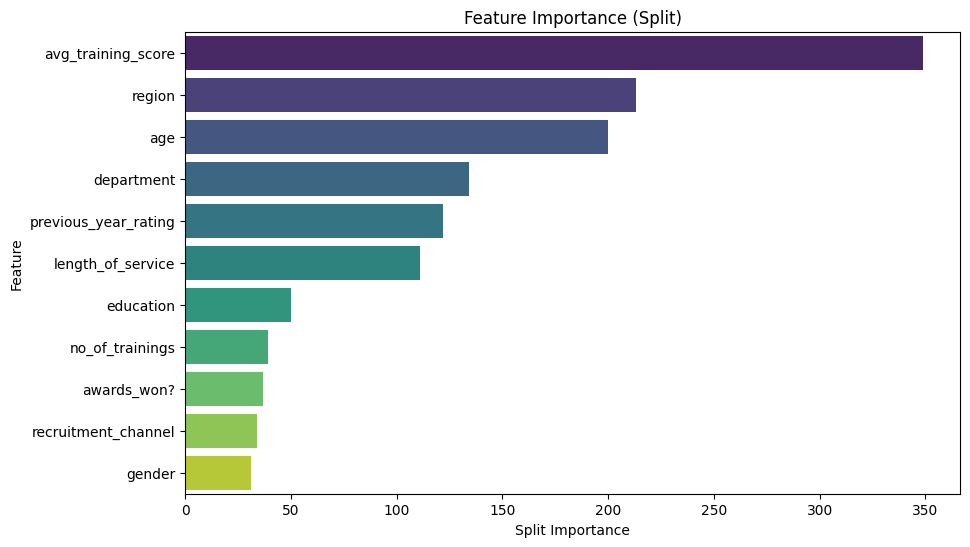

In [102]:
plt.figure(figsize=(10, 6))

sns.barplot(x='Split Importance', y='Feature', data=df_split_importance, palette='viridis')

plt.title('Feature Importance (Split)')
plt.show()

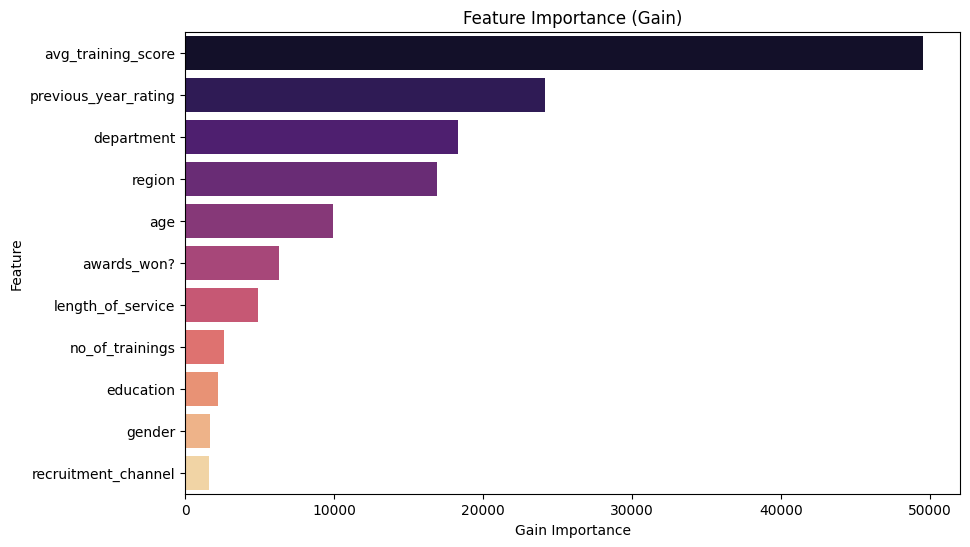

In [103]:
plt.figure(figsize=(10, 6))

sns.barplot(x='Gain Importance', y='Feature', data=df_gain_importance, palette='magma')

plt.title('Feature Importance (Gain)')
plt.show()

Note that `education` is not that important in terms of gain but is more important when we use split-based importances